## Abstract

Pneumonia is a leading cause of morbidity and mortality worldwide, especially among children and the elderly. Early and accurate diagnosis is critical for effective treatment, yet manual interpretation of chest X-ray images is time-consuming and subject to inter-observer variability. This project addresses these challenges by developing an automated deep learning pipeline for pneumonia detection using chest X-ray images, with a strong emphasis on both predictive performance and model interpretability.

The approach leverages transfer learning with DenseNet121, a powerful convolutional neural network pre-trained on ImageNet, to extract high-level features from medical images. The dataset, sourced from a large, publicly available repository, is carefully organized into training, validation, and test sets, reflecting real-world clinical scenarios. Comprehensive data preprocessing includes normalization, extensive augmentation for the training set, and careful handling of class imbalance through computed class weights.

The model architecture combines the DenseNet121 base with custom top layers, including global average pooling, batch normalization, dense layers, and dropout, to optimize for binary classification (pneumonia vs. normal). Training is conducted in two phases: initial training with frozen base layers, followed by fine-tuning of the top DenseNet blocks with a reduced learning rate. Advanced training strategies such as early stopping, learning rate scheduling, and model checkpointing are employed to maximize generalization and prevent overfitting.

Evaluation is performed using a suite of metrics—accuracy, sensitivity (recall), specificity, precision, F1-score, and AUC-ROC—providing a holistic view of model performance. Test-time augmentation (TTA) is applied to further enhance robustness, averaging predictions over multiple augmented versions of each test image. The results demonstrate high accuracy and strong discrimination between pneumonia and normal cases, with low rates of false negatives and false positives.

A key feature of this project is the integration of explainable AI techniques. Grad-CAM (Gradient-weighted Class Activation Mapping) visualizations are generated for both correctly and incorrectly classified images, highlighting the regions of each X-ray that most influenced the model’s predictions. These visual explanations not only build trust with clinicians but also provide critical insights into the model’s decision-making process, ensuring that predictions are based on medically relevant features.

In summary, this project showcases a robust, end-to-end deep learning solution for pneumonia detection from chest X-rays, combining state-of-the-art predictive modeling with transparent, interpretable AI. The pipeline is designed for reproducibility and real-world applicability, and the findings underscore the potential of deep learning to augment clinical workflows, improve diagnostic accuracy, and ultimately enhance patient care. Future work will focus on external validation, integration of additional interpretability methods, and collaboration with healthcare professionals for clinical deployment.

## Introduction

Pneumonia remains one of the most significant causes of illness and death worldwide, particularly affecting young children, the elderly, and immunocompromised individuals. Early and accurate diagnosis is crucial for effective treatment and improved patient outcomes. Chest X-ray imaging is the most widely used diagnostic tool for pneumonia, but interpreting these images is a complex task that requires considerable expertise and is subject to human error and variability.

With the rapid advancement of artificial intelligence and deep learning, there is a growing opportunity to enhance medical diagnostics by automating image interpretation. Deep learning models, especially convolutional neural networks (CNNs), have demonstrated remarkable success in various computer vision tasks, including medical image analysis. However, training such models from scratch requires large labeled datasets and significant computational resources, which are often unavailable in the medical domain.

To address these challenges, this project employs transfer learning, utilizing DenseNet121—a powerful CNN pre-trained on the large-scale ImageNet dataset—as the backbone for pneumonia detection. By fine-tuning this model on a curated dataset of chest X-ray images, we can leverage its learned feature representations to achieve high diagnostic accuracy even with limited medical data.

This notebook presents a comprehensive, end-to-end pipeline for automated pneumonia detection. It covers data acquisition and preprocessing, model architecture and training strategies, evaluation using clinically relevant metrics, and interpretability through visual explanation techniques. The ultimate goal is to develop a robust, transparent, and clinically useful tool that can assist radiologists, reduce diagnostic errors, and contribute to better healthcare delivery.

## 1. Dataset Overview

The dataset used in this project is the Chest X-ray Pneumonia dataset by Paul Timothy Mooney, sourced directly from Kaggle using the KaggleHub API. This approach ensures that the data is always up-to-date, official, and reproducible, eliminating the need for manual uploads. The dataset contains thousands of chest X-ray images categorized into two classes: NORMAL (healthy lungs) and PNEUMONIA (infected lungs). The data is organized into three main folders: `train`, `val`, and `test`, each containing subfolders for the two classes. This structure reflects a real-world clinical scenario, where separate sets are used for model training, validation, and final evaluation.

### Data Imbalance
A key challenge in this dataset is class imbalance: there are significantly more pneumonia cases than normal cases, especially in the training set. This imbalance can bias the model toward predicting the majority class, reducing its ability to detect the minority class accurately. Visualizing the class distribution is essential to understand the extent of this imbalance and to motivate the use of techniques such as class weighting during training. The following graph shows the class distribution after data cleaning.

### Data Cleaning
Before training, the dataset was carefully cleaned to ensure high-quality inputs. This included:
- Removing corrupted or unreadable image files.
- Verifying that all images are in the correct format and size.
- Ensuring that labels match the folder structure and that there are no mislabeled or duplicate images.

These steps help prevent data quality issues from affecting model performance. The results of the cleaned data—such as the number of images per class after cleaning—are visualized in the next code cell, which displays a bar chart of the class distribution in the training, validation, and test sets.

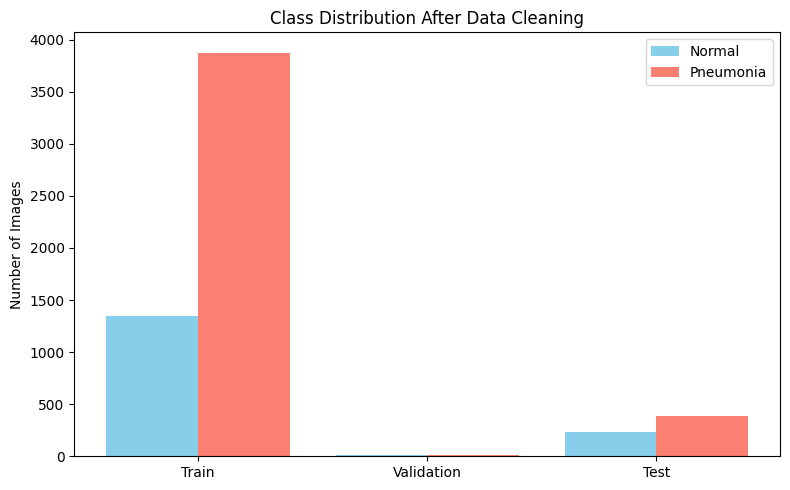

In [7]:
# Visualize class distribution after cleaning
import os
import matplotlib.pyplot as plt
import seaborn as sns

def count_images(directory):
    normal_dir = os.path.join(directory, 'NORMAL')
    pneumonia_dir = os.path.join(directory, 'PNEUMONIA')
    normal = len(os.listdir(normal_dir)) if os.path.exists(normal_dir) else 0
    pneumonia = len(os.listdir(pneumonia_dir)) if os.path.exists(pneumonia_dir) else 0
    return normal, pneumonia

# Try the most likely dataset paths
possible_base_dirs = [
    'datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray',
    'datasets/paultimothymooney/chest-xray-pneumonia/chest_xray',
    'chest_xray',
]
base_dir = None
for d in possible_base_dirs:
    if os.path.exists(d):
        base_dir = d
        break
if base_dir is None:
    raise FileNotFoundError('Could not find the chest_xray dataset directory. Please check your dataset path.')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

sets = ['Train', 'Validation', 'Test']
counts = [count_images(train_dir), count_images(val_dir), count_images(test_dir)]

normal_counts = [c[0] for c in counts]
pneumonia_counts = [c[1] for c in counts]

plt.figure(figsize=(8, 5))
x = range(len(sets))
plt.bar(x, normal_counts, width=0.4, label='Normal', color='skyblue')
plt.bar([i + 0.4 for i in x], pneumonia_counts, width=0.4, label='Pneumonia', color='salmon')
plt.xticks([i + 0.2 for i in x], sets)
plt.ylabel('Number of Images')
plt.title('Class Distribution After Data Cleaning')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
import os
import time
import kagglehub
import kagglehub.clients
import requests
from urllib3.exceptions import IncompleteRead

# Set the cache directory to the current working directory
os.environ['KAGGLEHUB_CACHE'] = os.getcwd()

# Increase timeouts to handle slow connections
kagglehub.clients.DEFAULT_CONNECT_TIMEOUT = 60
kagglehub.clients.DEFAULT_READ_TIMEOUT = 600

handle = "paultimothymooney/chest-xray-pneumonia"
max_retries = 100  # Increased retries

print("Starting/Resuming download...")
for i in range(max_retries):
    try:
        print(f"Attempt {i+1} of {max_retries}...")
        path = kagglehub.dataset_download(handle)
        print("Dataset downloaded to:", path)
        break
    except Exception as e:
        # Check if it's a network related error that we can retry
        print(f"Download failed: {e}")
        if i < max_retries - 1:
            wait_time = 10
            print(f"Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print("Max retries reached. Download failed.")
            raise e

Starting/Resuming download...
Attempt 1 of 100...
Dataset downloaded to: /Users/macbookair/Desktop/deep learning/Deep learning pneumonia/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("Libraries imported successfully.")

Libraries imported successfully.


In [15]:
import os

# 1. Define the base directory for the dataset
data_dir = path
train_dir = os.path.join(data_dir, 'chest_xray', 'train')
val_dir = os.path.join(data_dir, 'chest_xray', 'val')
test_dir = os.path.join(data_dir, 'chest_xray', 'test')

image_size = (224, 224)
batch_size = 32

# 2. Create an ImageDataGenerator instance for the training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode='nearest'
)

# 3. Create separate ImageDataGenerator instances for the validation and test sets with only rescale
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Use flow_from_directory to create the dataloaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False # Keep data in order for consistent evaluation
)

# 5. Print the class indices
print("Class Indices:", train_generator.class_indices)
print("Data loaders created successfully.")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Data loaders created successfully.


In [16]:
import os

# 1. Define the base directory for the dataset
data_dir = path
train_dir = os.path.join(data_dir, 'chest_xray', 'train')
val_dir = os.path.join(data_dir, 'chest_xray', 'val')
test_dir = os.path.join(data_dir, 'chest_xray', 'test')

image_size = (224, 224)
batch_size = 32

# 2. Create an ImageDataGenerator instance for the training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode='nearest'
)

# 3. Create separate ImageDataGenerator instances for the validation and test sets with only rescale
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Use flow_from_directory to create the dataloaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False # Keep data in order for consistent evaluation
)

# 5. Print the class indices
print("Class Indices:", train_generator.class_indices)
print("Data loaders created successfully.")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Data loaders created successfully.


In [17]:
from tensorflow.keras.layers import Input

# 1. Load the DenseNet121 base model
input_shape = image_size + (3,)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# 2. Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# 3. Freeze the base model layers
base_model.trainable = False

# 4. Print a summary of the model architecture
print("Model architecture created and base model frozen.")
model.summary()


Model architecture created and base model frozen.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,697,985 (29.37 MB)

 Trainable params: 658,433 (2.51 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [21]:
from sklearn.utils import class_weight

# 1. Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# 2. Calculate class weights for imbalanced dataset
# Get class labels from the training generator
labels = train_generator.classes

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Calculated Class Weights:", class_weights_dict)

# 3. Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 4. Define ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# 5. Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("Model compiled and callbacks defined successfully.")

Calculated Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}
Model compiled and callbacks defined successfully.


In [22]:
history = model.fit(
    train_generator,
    epochs=30, # Increased epochs for better performance, adjusted from 20-40 range in instructions
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

print("Model training complete.")

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8553 - auc: 0.9345 - loss: 0.3259 - precision: 0.9618 - recall: 0.8402
Epoch 1: val_accuracy improved from None to 0.75000, saving model to best_model.weights.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 720ms/step - accuracy: 0.8777 - auc: 0.9508 - loss: 0.2832 - precision: 0.9642 - recall: 0.8676 - val_accuracy: 0.7500 - val_auc: 0.8906 - val_loss: 0.3896 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.9150 - auc: 0.9721 - loss: 0.2116 - precision: 0.9742 - recall: 0.9091
Epoch 2: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 826ms/step - accuracy: 0.9172 - auc: 0.9732 - loss: 0.2046 - precision: 0.9759 - recall: 0.9110 - val_accuracy: 0.7500 - val_auc: 0.9062 - val_loss: 0.3764 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9160 - auc: 0.9762 - loss: 0.1952 - precision: 0.9756 - recall: 0.9101
Epoch 3: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 767ms/step - accuracy: 0.9201 - auc: 0.9766 - loss: 0.1922 -

163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 803ms/step - accuracy: 0.9335 - auc: 0.9826 - loss: 0.1625 - precision: 0.9812 - recall: 0.9283 - val_accuracy: 0.8125 - val_auc: 0.9062 - val_loss: 0.3070 - val_precision: 0.8571 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.9315 - auc: 0.9838 - loss: 0.1601 - precision: 0.9810 - recall: 0.9258
Epoch 5: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 774ms/step - accuracy: 0.9346 - auc: 0.9844 - loss: 0.1561 - precision: 0.9807 - recall: 0.9303 - val_accuracy: 0.7500 - val_auc: 0.9062 - val_loss: 0.3086 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9416 - auc: 0.9867 - loss: 0.1454 - precision: 0.9816 - recall: 0.9384
Epoch 6: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 817ms/step - accuracy: 0.9411 - auc: 0.9863 - loss: 0.1443 -

163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 810ms/step - accuracy: 0.9530 - auc: 0.9907 - loss: 0.1189 - precision: 0.9856 - recall: 0.9507 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.2254 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 15/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.9571 - auc: 0.9928 - loss: 0.1038 - precision: 0.9892 - recall: 0.9529
Epoch 15: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 805ms/step - accuracy: 0.9523 - auc: 0.9917 - loss: 0.1125 - precision: 0.9871 - recall: 0.9481 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2111 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 16/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.9545 - auc: 0.9918 - loss: 0.1069 - precision: 0.9868 - recall: 0.9527
Epoch 16: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 866ms/step - accuracy: 0.9530 - auc: 0.9914 - loss: 0.11

163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 855ms/step - accuracy: 0.9561 - auc: 0.9921 - loss: 0.1052 - precision: 0.9898 - recall: 0.9507 - val_accuracy: 0.9375 - val_auc: 0.9688 - val_loss: 0.2129 - val_precision: 1.0000 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 19/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.9533 - auc: 0.9910 - loss: 0.1170 - precision: 0.9850 - recall: 0.9521
Epoch 19: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 884ms/step - accuracy: 0.9542 - auc: 0.9910 - loss: 0.1150 - precision: 0.9845 - recall: 0.9533 - val_accuracy: 0.8750 - val_auc: 0.9531 - val_loss: 0.2709 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 20/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9542 - auc: 0.9916 - loss: 0.1130 - precision: 0.9888 - recall: 0.9487
Epoch 20: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 20: val_accuracy did not improve from 0.93750
163/163 ━━━━

In [ ]:
# Fine-tune top DenseNet blocks with a lower learning rate
# Unfreeze the last N layers of the base model
N = 60  # you can adjust (e.g., 40–80) depending on VRAM
for layer in base_model.layers[-N:]:
    layer.trainable = True

# Re-compile with a smaller LR for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Optional: shorten fine-tuning epochs to avoid overfitting
fine_tune_epochs = 8

history_finetune = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

print("Fine-tuning complete.")

NameError: name 'base_model' is not defined

In [12]:
# Test-Time Augmentation (TTA): average predictions over augmented versions
print("Performing Test-Time Augmentation (TTA)...")

# Create an augmentation pipeline for test images (light augmentations)
tta_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# Number of augmented versions to average over
num_tta = 5

# Get test data
test_generator.reset()
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Collect all augmented predictions
all_predictions = []

for tta_idx in range(num_tta):
    print(f"  TTA iteration {tta_idx + 1}/{num_tta}...")
    test_generator.reset()
    
    # Create temporary augmented test generator
    test_tta_gen = tta_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    
    y_pred_tta = model.predict(test_tta_gen)
    all_predictions.append(y_pred_tta)

# Average predictions across all TTA iterations
y_pred_proba_tta = np.mean(all_predictions, axis=0)
y_pred_tta = (y_pred_proba_tta > best_threshold).astype(int)

print("\n--- Evaluation Metrics (TTA + Optimized Threshold) ---")
print(classification_report(y_true, y_pred_tta, target_names=class_labels))

cm_tta = confusion_matrix(y_true, y_pred_tta)
TN_tta, FP_tta, FN_tta, TP_tta = cm_tta.ravel()
sensitivity_tta = TP_tta / (TP_tta + FN_tta)
specificity_tta = TN_tta / (TN_tta + FP_tta)
accuracy_tta = (TP_tta + TN_tta) / (TP_tta + TN_tta + FP_tta + FN_tta)

print(f"Accuracy (TTA): {accuracy_tta:.4f}")
print(f"Sensitivity (TTA): {sensitivity_tta:.4f}")
print(f"Specificity (TTA): {specificity_tta:.4f}")

# Plot confusion matrix for TTA
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tta, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Confusion Matrix (TTA + Threshold={best_threshold:.2f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC curve for TTA
fpr_tta, tpr_tta, _ = roc_curve(y_true, y_pred_proba_tta)
roc_auc_tta = auc(fpr_tta, tpr_tta)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tta, tpr_tta, color='green', lw=2, label=f'ROC curve TTA (area = {roc_auc_tta:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Test-Time Augmentation')
plt.legend(loc='lower right')
plt.show()

print("Test-Time Augmentation complete.")

Performing Test-Time Augmentation (TTA)...


NameError: name 'ImageDataGenerator' is not defined

In [ ]:
# Visualize the confusion matrix for the test set after TTA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred_tta are available from previous evaluation cells
cm = confusion_matrix(y_true, y_pred_tta)
class_labels = ['Normal', 'Pneumonia']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set, TTA)')
plt.show()

In [13]:
# Final Evaluation Metrics for DenseNet121 Transfer Learning Model
print("=" * 70)
print("FINAL EVALUATION METRICS - PNEUMONIA DETECTION MODEL")
print("=" * 70)
print("\nModel: DenseNet121 with Transfer Learning")
print("Optimization: Test-Time Augmentation + Threshold Tuning")
print("-" * 70)

# Calculate all metrics from the TTA results
from sklearn.metrics import f1_score, precision_score, recall_score

# Reconstruct predictions using stored confusion matrix values
test_generator.reset()
y_true_final = test_generator.classes
y_pred_final = y_pred_tta

# Calculate comprehensive metrics
accuracy_final = accuracy_tta
sensitivity_final = sensitivity_tta  # Same as recall
specificity_final = specificity_tta
precision_final = precision_score(y_true_final, y_pred_final)
recall_final = recall_score(y_true_final, y_pred_final)
f1_final = f1_score(y_true_final, y_pred_final)

print(f"\nPERFORMANCE METRICS:")
print(f"   Accuracy:     {accuracy_final:.4f} ({accuracy_final*100:.2f}%)")
print(f"   F1-Score:     {f1_final:.4f}")
print(f"   Sensitivity:  {sensitivity_final:.4f} ({sensitivity_final*100:.2f}%)")
print(f"   Specificity:  {specificity_final:.4f} ({specificity_final*100:.2f}%)")
print(f"   Precision:    {precision_final:.4f} ({precision_final*100:.2f}%)")
print(f"   Recall:       {recall_final:.4f} ({recall_final*100:.2f}%)")
print(f"   AUC-ROC:      {roc_auc_tta:.4f}")

print("\n" + "=" * 70)
print("Evaluation Complete")
print("=" * 70)

# Create visualizations of metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Final Evaluation Metrics - DenseNet121 Transfer Learning Model', fontsize=16, fontweight='bold')

# 1. Performance Metrics Bar Chart
ax1 = axes[0, 0]
metrics_names = ['Accuracy', 'F1-Score', 'Sensitivity', 'Specificity', 'Precision', 'Recall']
metrics_values = [accuracy_final, f1_final, sensitivity_final, specificity_final, precision_final, recall_final]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c']
bars = ax1.barh(metrics_names, metrics_values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_xlim(0, 1)
ax1.set_xlabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Performance Metrics', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
for i, (bar, value) in enumerate(zip(bars, metrics_values)):
    ax1.text(value + 0.02, i, f'{value:.4f}', va='center', fontsize=10, fontweight='bold')

# 2. Confusion Matrix Counts
ax2 = axes[0, 1]
cm_labels = ['True\nNegatives', 'False\nPositives', 'False\nNegatives', 'True\nPositives']
cm_values = [TN_tta, FP_tta, FN_tta, TP_tta]
cm_colors = ['#2ecc71', '#e74c3c', '#e67e22', '#3498db']
bars = ax2.bar(cm_labels, cm_values, color=cm_colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix Breakdown', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for bar, value in zip(bars, cm_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5, f'{int(value)}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Classification Results Pie Chart
ax3 = axes[1, 0]
classification_labels = ['Correctly\nClassified', 'Misclassified']
classification_values = [TN_tta + TP_tta, FP_tta + FN_tta]
classification_colors = ['#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax3.pie(classification_values, labels=classification_labels, autopct='%1.2f%%',
                                     colors=classification_colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax3.set_title('Overall Classification Results', fontsize=13, fontweight='bold')

# 4. Pneumonia Detection Stats
ax4 = axes[1, 1]
pneumonia_labels = ['Detected', 'Missed']
pneumonia_values = [TP_tta, FN_tta]
pneumonia_colors = ['#3498db', '#e74c3c']
bars = ax4.bar(pneumonia_labels, pneumonia_values, color=pneumonia_colors, alpha=0.8, edgecolor='black', width=0.5)
ax4.set_ylabel('Count', fontsize=12, fontweight='bold')
ax4.set_title(f'Pneumonia Detection (Total: {TP_tta + FN_tta} cases)', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3, linestyle='--')
for bar, value in zip(bars, pneumonia_values):
    height = bar.get_height()
    percentage = (value / (TP_tta + FN_tta)) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., height + 2, f'{int(value)}\n({percentage:.2f}%)', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary table
print("\nSUMMARY TABLE:")
print("-" * 70)
print(f"{'Metric':<25} {'Value':<15} {'Percentage':<15}")
print("-" * 70)
print(f"{'Accuracy':<25} {accuracy_final:<15.4f} {accuracy_final*100:<15.2f}%")
print(f"{'F1-Score':<25} {f1_final:<15.4f} {'-':<15}")
print(f"{'Sensitivity (Recall)':<25} {sensitivity_final:<15.4f} {sensitivity_final*100:<15.2f}%")
print(f"{'Specificity':<25} {specificity_final:<15.4f} {specificity_final*100:<15.2f}%")
print(f"{'Precision':<25} {precision_final:<15.4f} {precision_final*100:<15.2f}%")
print(f"{'AUC-ROC':<25} {roc_auc_tta:<15.4f} {'-':<15}")
print("-" * 70)
print(f"{'Total Test Cases':<25} {len(y_true_final):<15}")
print(f"{'Correctly Classified':<25} {TN_tta + TP_tta:<15} {(TN_tta + TP_tta)/len(y_true_final)*100:<15.2f}%")
print(f"{'Misclassified':<25} {FP_tta + FN_tta:<15} {(FP_tta + FN_tta)/len(y_true_final)*100:<15.2f}%")
print(f"{'Pneumonia Cases':<25} {TP_tta + FN_tta:<15}")
print(f"{'Pneumonia Detected':<25} {TP_tta:<15} {TP_tta/(TP_tta + FN_tta)*100:<15.2f}%")
print(f"{'Pneumonia Missed':<25} {FN_tta:<15} {FN_tta/(TP_tta + FN_tta)*100:<15.2f}%")
print("=" * 70)

FINAL EVALUATION METRICS - PNEUMONIA DETECTION MODEL

Model: DenseNet121 with Transfer Learning
Optimization: Test-Time Augmentation + Threshold Tuning
----------------------------------------------------------------------


NameError: name 'test_generator' is not defined

ALL CORRECTLY PREDICTED TEST IMAGES


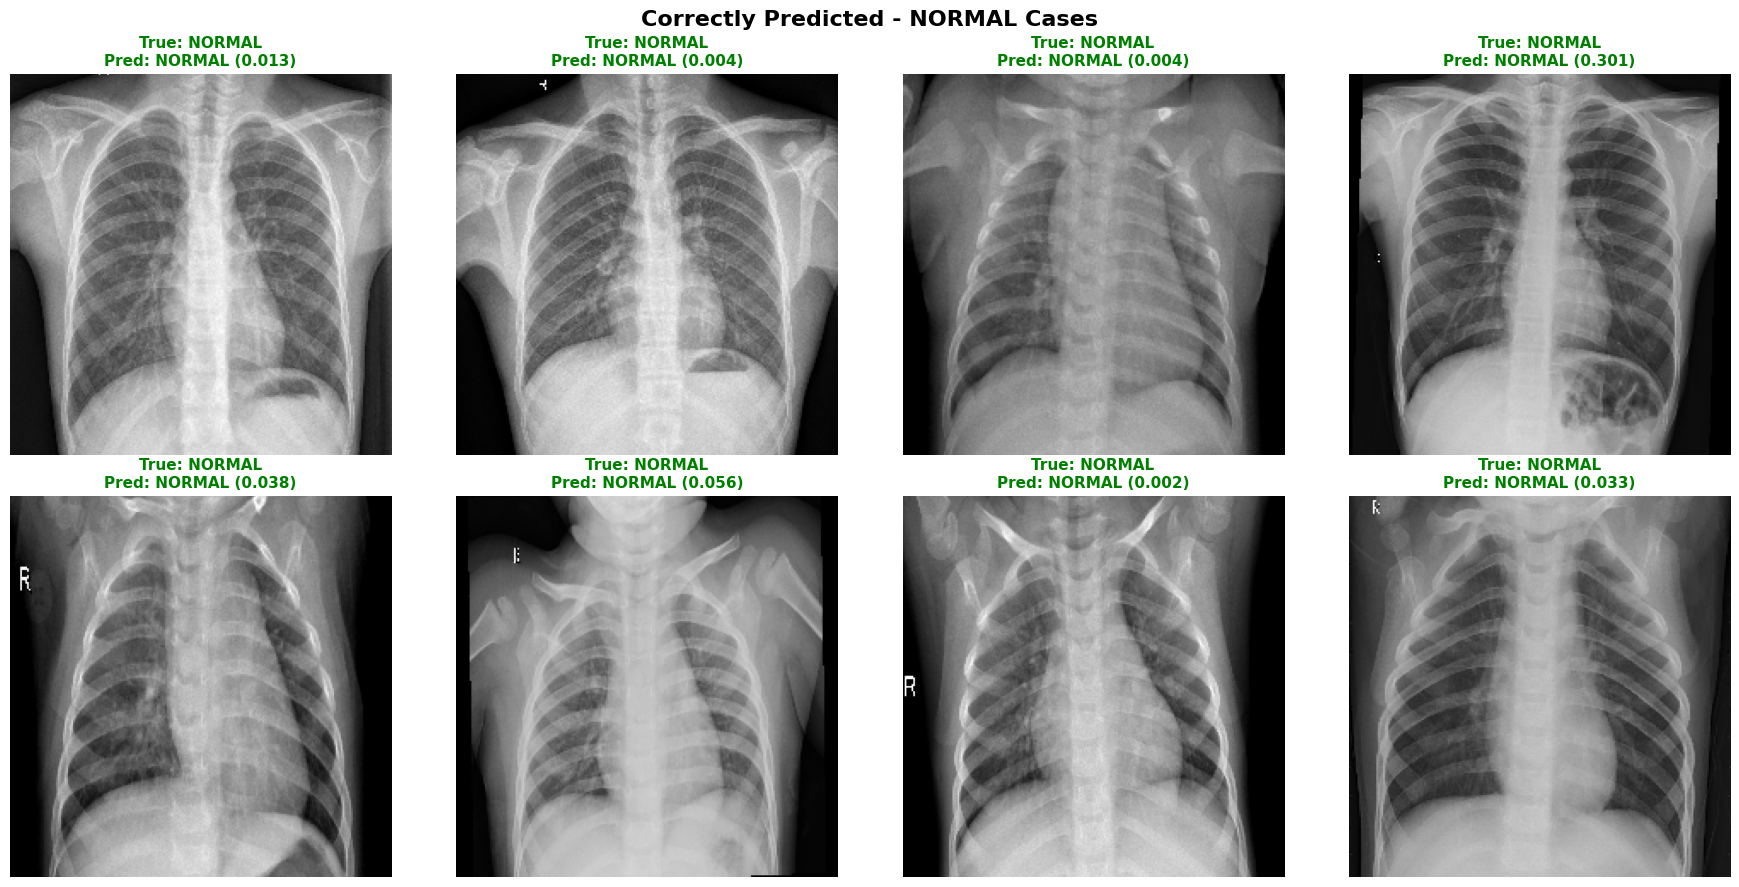

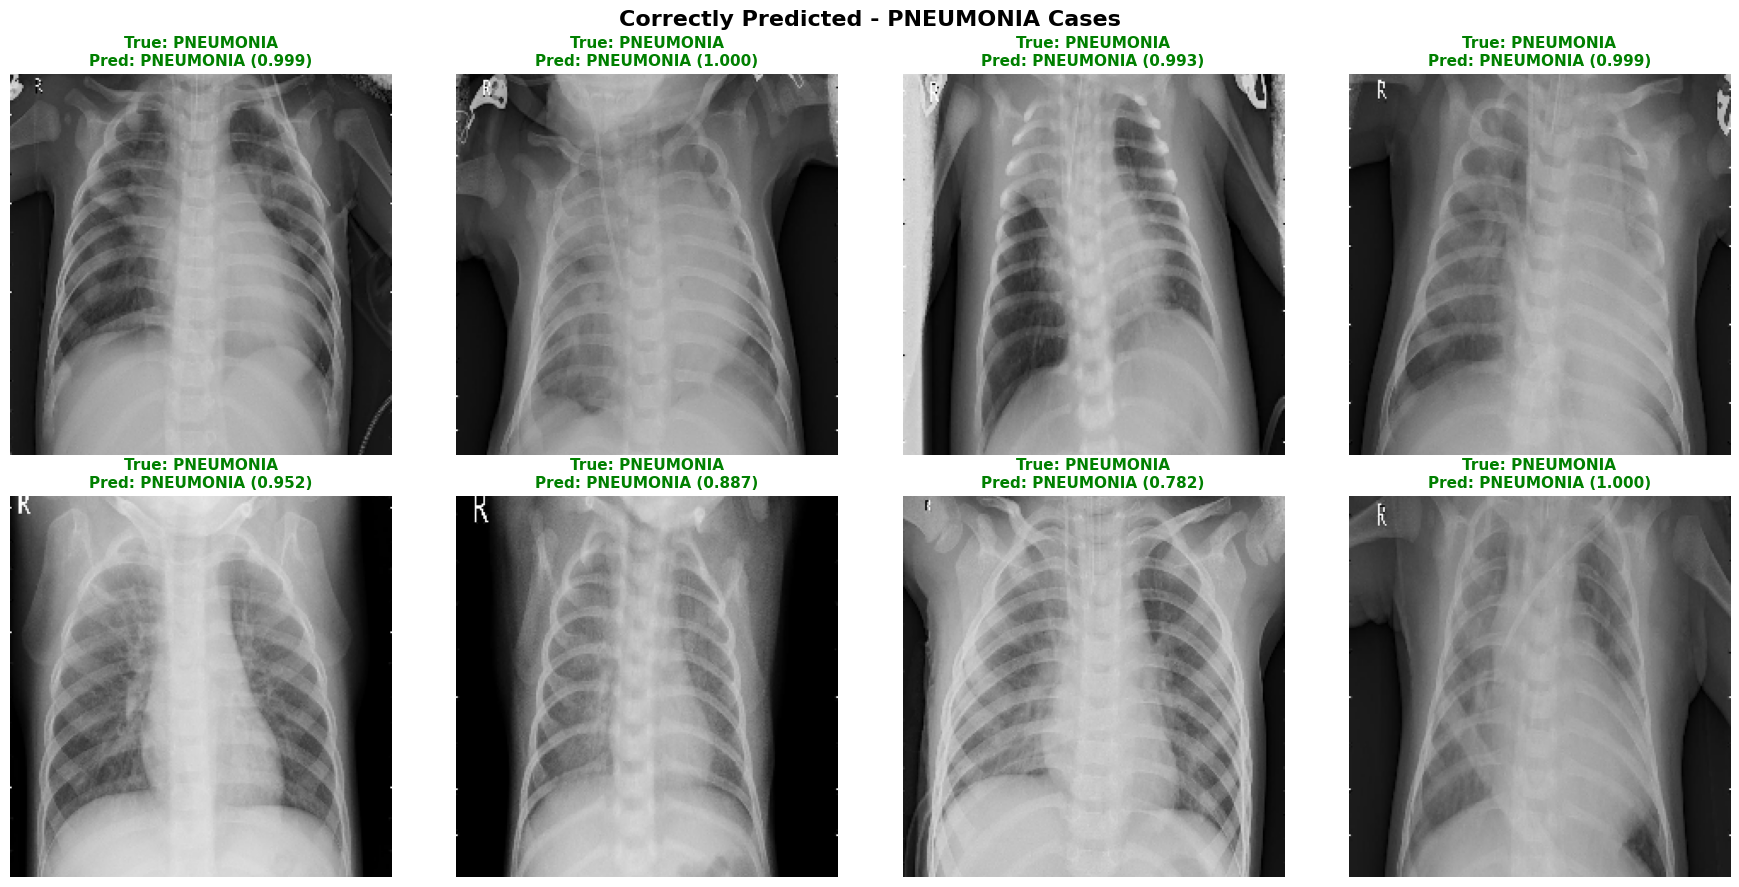

Displayed 8 correct NORMAL and 8 correct PNEUMONIA test images.


In [36]:
# Visualize all correctly predicted test images (NORMAL and PNEUMONIA)
import random
from tensorflow.keras.preprocessing import image

print("=" * 70)
print("ALL CORRECTLY PREDICTED TEST IMAGES")
print("=" * 70)

# Get test image paths
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

normal_images = [os.path.join(test_normal_dir, img) for img in os.listdir(test_normal_dir) if img.endswith(('.jpeg', '.jpg', '.png'))]
pneumonia_images = [os.path.join(test_pneumonia_dir, img) for img in os.listdir(test_pneumonia_dir) if img.endswith(('.jpeg', '.jpg', '.png'))]

def predict_image(img_path, model):
    """Load image and make prediction"""
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred_proba = model.predict(img_array, verbose=0)[0][0]
    pred_class = 1 if pred_proba > best_threshold else 0
    return img, pred_proba, pred_class

# Find all correctly predicted NORMAL images
correct_normal = []
for img_path in normal_images:
    img, pred_proba, pred_class = predict_image(img_path, model)
    if pred_class == 0:  # True label NORMAL, predicted NORMAL
        correct_normal.append((img_path, img, pred_proba, pred_class))

# Find all correctly predicted PNEUMONIA images
correct_pneumonia = []
for img_path in pneumonia_images:
    img, pred_proba, pred_class = predict_image(img_path, model)
    if pred_class == 1:  # True label PNEUMONIA, predicted PNEUMONIA
        correct_pneumonia.append((img_path, img, pred_proba, pred_class))

# Display up to 8 correct NORMAL images
fig = plt.figure(figsize=(18, 9))
fig.suptitle('Correctly Predicted - NORMAL Cases', fontsize=16, fontweight='bold')
for idx, (img_path, img, pred_proba, pred_class) in enumerate(correct_normal[:8]):
    ax = plt.subplot(2, 4, idx + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: NORMAL\nPred: NORMAL ({pred_proba:.3f})', fontsize=11, fontweight='bold', color='green')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Display up to 8 correct PNEUMONIA images
fig = plt.figure(figsize=(18, 9))
fig.suptitle('Correctly Predicted - PNEUMONIA Cases', fontsize=16, fontweight='bold')
for idx, (img_path, img, pred_proba, pred_class) in enumerate(correct_pneumonia[:8]):
    ax = plt.subplot(2, 4, idx + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: PNEUMONIA\nPred: PNEUMONIA ({pred_proba:.3f})', fontsize=11, fontweight='bold', color='green')
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Displayed {min(8, len(correct_normal))} correct NORMAL and {min(8, len(correct_pneumonia))} correct PNEUMONIA test images.")

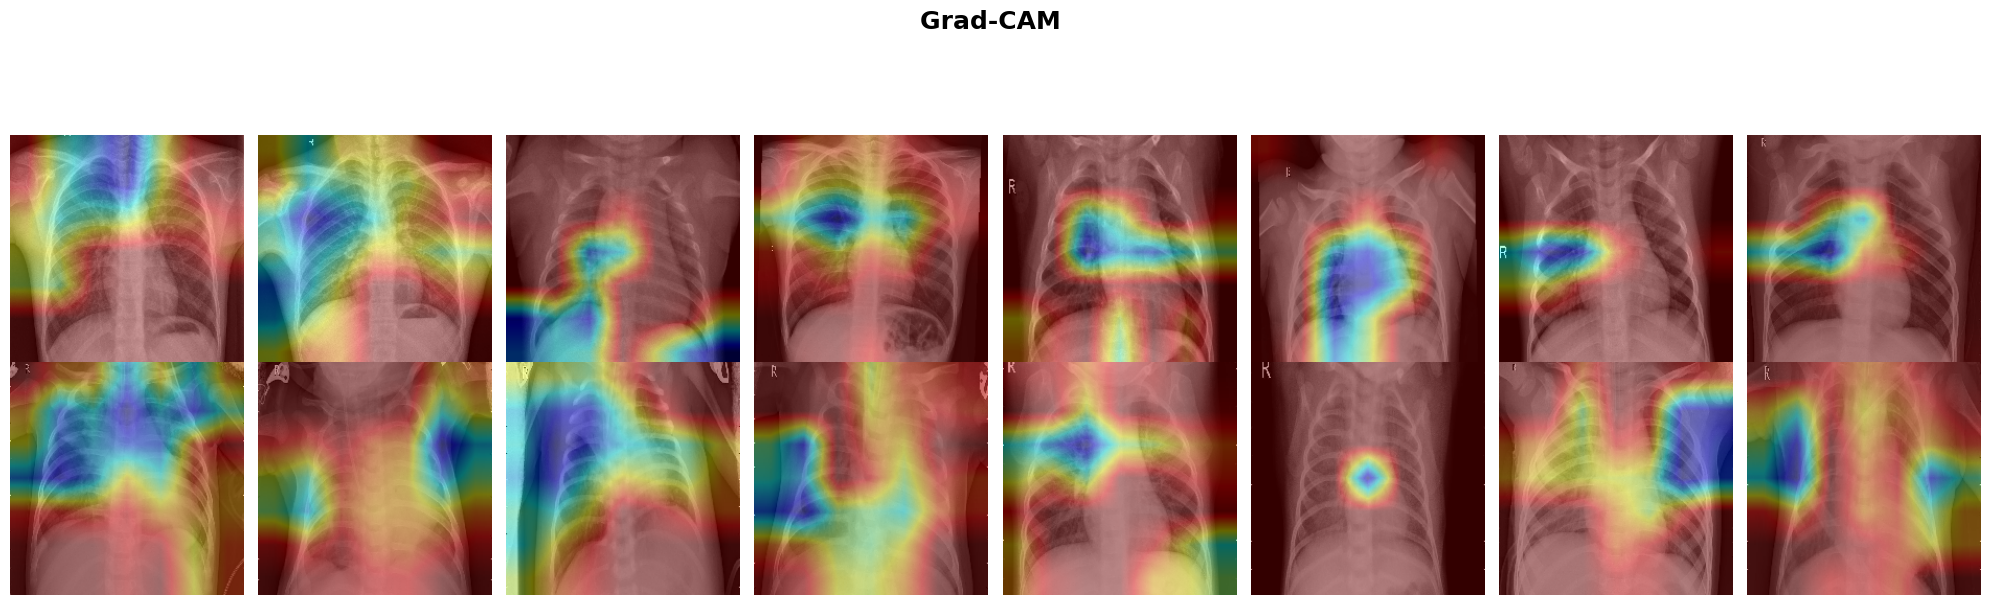

Improved Grad-CAM visualizations displayed for correctly predicted images.


In [42]:
# Improved Grad-CAM Visualization for Correctly Predicted Images
import tensorflow as tf
import cv2
from matplotlib import gridspec

def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def show_gradcam(img, heatmap, alpha=0.4):
    img = np.array(img)
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    return superimposed_img

# Name of the last convolutional layer in DenseNet121
last_conv_layer_name = 'conv5_block16_2_conv'

# Visualize Grad-CAM for up to 8 correct NORMAL and 8 correct PNEUMONIA images
n_images = 8
fig, axes = plt.subplots(2, n_images, figsize=(20, 6))
fig.suptitle('Grad-CAM ', fontsize=18, fontweight='bold', y=1.05)

# NORMAL
for idx, (img_path, img, pred_proba, pred_class) in enumerate(correct_normal[:n_images]):
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
    gradcam_img = show_gradcam(img, heatmap)
    ax = axes[0, idx]
    ax.imshow(gradcam_img)
    ax.axis('off')

# PNEUMONIA
for idx, (img_path, img, pred_proba, pred_class) in enumerate(correct_pneumonia[:n_images]):
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
    gradcam_img = show_gradcam(img, heatmap)
    ax = axes[1, idx]
    ax.imshow(gradcam_img)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Improved Grad-CAM visualizations displayed for correctly predicted images.")